# Week 4 - Transfer Learning - Horse2Zebra Dataset

Author: Khushee Kapoor

Last Updated: 19/8/22

To start, we first degrade the version of Tensorflow so as to utilize GPU for optimizing training.

In [ ]:
# degrading the tensorflow version
!pip install tensorflow==2.8
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Next, we import the following libraries:

- NumPy: for data manipulation
- Pandas: for data manipulation
- Matplotlib: for data visualization
- Seaborn: for data visualization
- Tensorflow: to build neural networks
- OS: for manipulating the data directories
- Zipfile: for data importing
- shutil: for manipulating the data directories
- PIL: to deal with images

In [2]:
# importing the libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import zipfile
import shutil
import PIL.Image as Image

To start, we first import the dataset from the link provided.

In [3]:
# importing the data
if not os.path.exists('./horse2zebra'):
  import gdown
  url = 'https://drive.google.com/uc?id=1jPelB2jzNZJq3ZU9Uk_Mkt4MJtF3DRgg'
  gdown.download(url, './horse2zebra.zip', quiet=False)
  !unzip ./horse2zebra.zip > /dev/null

Downloading...
From: https://drive.google.com/uc?id=1jPelB2jzNZJq3ZU9Uk_Mkt4MJtF3DRgg
To: /content/horse2zebra.zip
100%|██████████| 117M/117M [00:00<00:00, 153MB/s]


After that, we sort out the images and create training and testing directories to store the images.

In [4]:
# extracting the training images
for root, dirs, files in os.walk('./horse2zebra'):
    if root.endswith('/train/A'):
        filenames_horses=files
    if root.endswith('/train/B'):
        filenames_zebras=files

# sorting the filenames
filenames_horses_sort=sorted(filenames_horses)
filenames_zebras_sort=sorted(filenames_zebras)

horses_root='./horse2zebra/train/A'
zebras_root='./horse2zebra/train/B'

horses_train=[]
zebras_train=[]

# saving all the images in the appropriate directories
for i in range(len(filenames_horses_sort)):
          horses_train.append(Image.open(os.path.join(horses_root, filenames_horses_sort[i])).convert('RGB'))

for i in range(len(filenames_zebras_sort)):
          zebras_train.append(Image.open(os.path.join(zebras_root, filenames_zebras_sort[i])).convert('RGB'))

train_dir = './horse2zebra/train'

In [5]:
# extracting the testing images
for root, dirs, files in os.walk('./horse2zebra'):
    if root.endswith('/test/A'):
        filenames_horses=files
    if root.endswith('/test/B'):
        filenames_zebras=files

# sorting the filenames
filenames_horses_sort=sorted(filenames_horses)
filenames_zebras_sort=sorted(filenames_zebras)

horses_root='./horse2zebra/test/A'
zebras_root='./horse2zebra/test/B'

horses_test=[]
zebras_test=[]

# saving all the images in the appropriate directories
for i in range(len(filenames_horses_sort)):
          horses_test.append(Image.open(os.path.join(horses_root, filenames_horses_sort[i])).convert('RGB'))

for i in range(len(filenames_zebras_sort)):
          zebras_test.append(Image.open(os.path.join(zebras_root, filenames_zebras_sort[i])).convert('RGB'))

test_dir = './horse2zebra/test'

To get a glimpse of the dataset, we print out one of the images using functions from the matplotlib library.

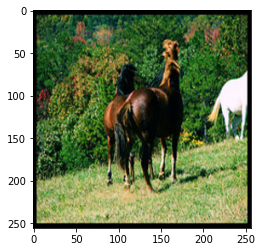

In [6]:
# printing out one image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(mpimg.imread(os.path.join(horses_root, filenames_horses_sort[0])))

Now, since we don't really have a validation set, we create a validation set and move the first 100 images from the training set to the validation set using functions from the os library.

In [8]:
# creating a validation directory
val_dir = os.path.join('./horse2zebra', 'val')
val_horse_dir = os.path.join(val_dir, 'A')
val_zebra_dir = os.path.join(val_dir, 'B')
os.mkdir(val_dir) 
os.mkdir(os.path.join(val_dir, 'A'))
os.mkdir(os.path.join(val_dir, 'B'))

# obtaining the image names in the training directory
train_horse_dir = os.path.join(train_dir, 'A')
train_horse_fnames = os.listdir(train_horse_dir)
train_zebra_dir = os.path.join(train_dir, 'B')
train_zebra_fnames = os.listdir(train_zebra_dir)

# moving the first 100 images to the corresponding validation data folder
for i in range(100):
  shutil.move(os.path.join(train_horse_dir,train_horse_fnames[i]),val_horse_dir)
  shutil.move(os.path.join(train_zebra_dir,train_zebra_fnames[i]),val_zebra_dir)

After that, we use the ImageDataGenerator to generate the training, testing, and validation datasets and normalize the images.

In [7]:
# creating pipelines to generate and normalize the images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

Now we try out the following networks for image classification:

- VGG16
- GoogleNet
- ResNet50
- EfficientNet B0
- Mobile Net V2

## VGG-16

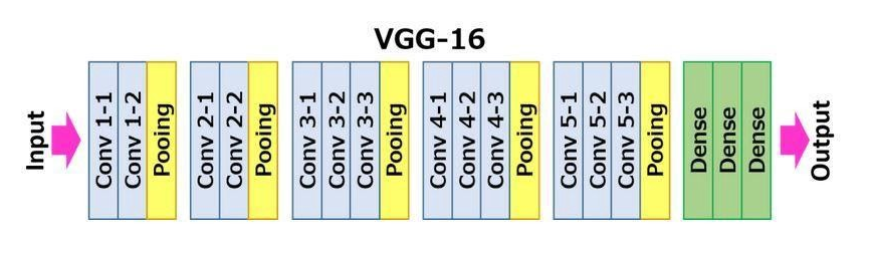

To begin, we implement the previously created data generators to generate the train, test, and validation sets and resize the images to 224x224 for the network implementation.

In [9]:
# flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size=(224, 224), # rescaling the images to 224x224
        batch_size=20,
        class_mode='categorical')

Found 2201 images belonging to 2 classes.


In [10]:
# flow validaiton images in batches of 20 using val_datagen generator
val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224), # rescaling the images to 224x224
        batch_size=20,
        class_mode='categorical')

Found 200 images belonging to 2 classes.


In [11]:
# flow test images in batches of 20 using test_datagen generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224), # rescaling the images to 224x224
        batch_size=20,
        class_mode='categorical')

Found 260 images belonging to 2 classes.


Next, we use the concept of Transfer Learning to use VGG-16's pre-trained weights and biases for image classification. To do this, we import the base model of VGG-16 from the Keras library.

In [12]:
# importing the network
from keras.applications.vgg16 import VGG16
base_model = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
base_model.trainable = False # freezing the layers
base_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

After that, we add in a Deep Neural Network at the tail of the base model which flattens the features generated during convolution to make predictions using 2 nodes and the 'sigmoid' activation. We also compile the model and set the optimizer to be 'adam' with learning rate to be 0.0001, loss to be 'categorical_crossentropy' and metric to be 'accuracy'

In [13]:
# adding a deep neural network to make predictions
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='sigmoid')
])
model.summary()

# compiling the network
model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 2)                 50178     
                                                                 
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


To obtain a pictorial representation of the network, we use the plot_model() function from the Tensorflow library.

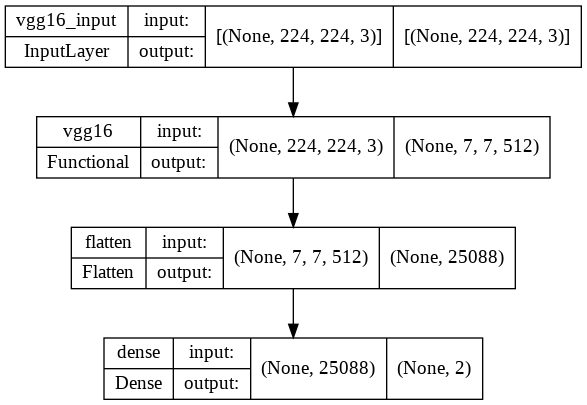

In [14]:
# obtaining a pictorial representation of the network
from tensorflow.keras.utils import plot_model
plot_model(model,  show_shapes=True, show_layer_names=True)

After that, we train the model on the training data generator with number of epochs set to 10 (optimum value set after trial and error of various combinations of accuracy and loss) and validation data to be used from the validation data generator.

In [15]:
# training the network
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
111/111 [==============================] - 24s 135ms/step - loss: 0.3070 - acc: 0.8823 - val_loss: 0.1821 - val_acc: 0.9550
Epoch 2/10
111/111 [==============================] - 14s 128ms/step - loss: 0.1512 - acc: 0.9537 - val_loss: 0.1434 - val_acc: 0.9650
Epoch 3/10
111/111 [==============================] - 14s 130ms/step - loss: 0.1158 - acc: 0.9700 - val_loss: 0.1146 - val_acc: 0.9600
Epoch 4/10
111/111 [==============================] - 15s 138ms/step - loss: 0.0963 - acc: 0.9750 - val_loss: 0.1266 - val_acc: 0.9650
Epoch 5/10
111/111 [==============================] - 15s 133ms/step - loss: 0.0805 - acc: 0.9818 - val_loss: 0.0970 - val_acc: 0.9750
Epoch 6/10
111/111 [==============================] - 15s 134ms/step - loss: 0.0701 - acc: 0.9836 - val_loss: 0.0992 - val_acc: 0.9800
Epoch 7/10
111/111 [==============================] - 15s 134ms/step - loss: 0.0605 - acc: 0.9873 - val_loss: 0.0947 - val_acc: 0.9750
Epoch 8/10
111/111 [==============================] - 1

We then compare the training and validation accuracies. To do this, we use the history attribute and extract the accuracies of the models. Next, we plot it against the number of epochs using functions from the MatPlotLib library.

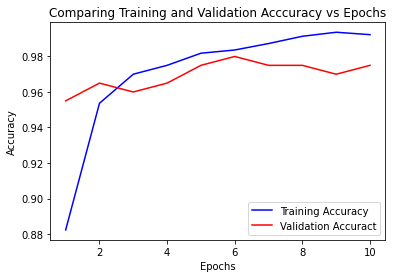

In [16]:
# extracting the model accuracy against epochs
ta = history.history['acc']
va = history.history['val_acc']
epochs = range(1,11)

# plotting the accuracies
plt.figure()
plt.plot(epochs, ta, 'b', label='Training Accuracy')
plt.plot(epochs, va, 'r', label='Validation Accuract')
plt.title('Comparing Training and Validation Acccuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

As we can see, the training accuracy has a parabolic increasing curve, whereas the validation accuracy has a slight upward trend with some fluctuations. There is some difference between the training and validation accuracies.

Next, we compare the training and validation losses. To do this, we use the history attribute and extract the losses of the models. Next, we plot it against the number of epochs using functions from the MatPlotLib library.

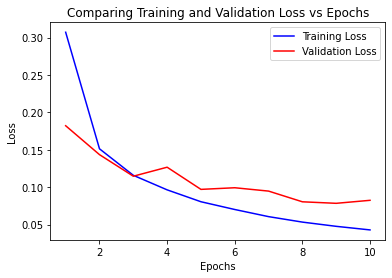

In [17]:
# extracting the model loss against epochs
tl = history.history['loss']
vl = history.history['val_loss']
epochs = range(1,11)

# plotting the losses
plt.figure()
plt.plot(epochs, tl, 'b', label='Training Loss')
plt.plot(epochs, vl, 'r', label='Validation Loss')
plt.title('Comparing Training and Validation Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

As we can see, the training loss has a parabolic decreasing curve, whereas the validation loss has a slight downward trend with some fluctuations. There is some difference between the training and validation losses.

To evaluate the performance of the model on the test set, we use the evaluate() function and print the model's accuracy on the testing set.

In [18]:
# evaluating the model on the testing set
print(str.format('Accuracy on Test Set: {:.2f}%', model.evaluate(test_generator)[1]*100))

13/13 [==============================] - 2s 132ms/step - loss: 0.0811 - acc: 0.9731
Accuracy on Test Set: 97.31%


As we can see, the model has an accuracy of 97.31% on the test set, which indicates that the model performes really well.

## Google Net

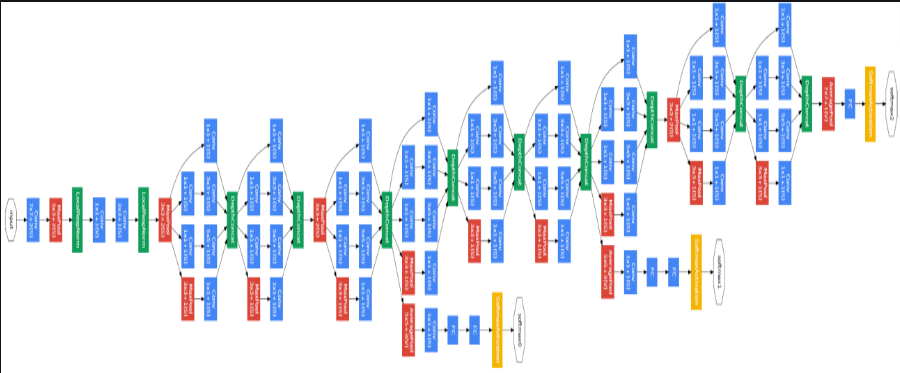

To begin, we implement the previously created data generators to generate the train, test, and validation sets and resize the images to 299x299 for the network implementation.

In [20]:
# flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size=(299, 299), # resclaing the images to 299 x 299
        batch_size=20,
        class_mode='categorical')

Found 2201 images belonging to 2 classes.


In [21]:
# flow validation images in batches of 20 using val_datagen generator
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(299, 299), # resclaing the images to 299 x 299
    batch_size=20,
    class_mode='categorical')

Found 200 images belonging to 2 classes.


In [22]:
# flow test images in batches of 20 using test_datagen generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(299, 299), # resclaing the images to 299 x 299
        batch_size=20,
        class_mode='categorical')

Found 260 images belonging to 2 classes.


Next, we use the concept of Transfer Learning to use GoogleNet's pre-trained weights and biases for image classification. To do this, we import the base model of InceptionNet (GoogleNet) from the Keras library.

In [23]:
# importing the network
from keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape=(299,299,3), weights='imagenet', include_top=False)
base_model.trainable = False # freezing the layers
base_model.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)           

After that, we add in a Deep Neural Network at the tail of the base model which flattens the features generated during convolution to make predictions using 2 nodes and the 'sigmoid' activation. We also compile the model and set the optimizer to be 'adam' with learning rate to be 0.0001, loss to be 'categorical_crossentropy' and metric to be 'accuracy'.

In [24]:
# adding a deep neural network to make predictions
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='sigmoid')
])
model.summary()

# compiling the network
model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['acc'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_1 (Dense)             (None, 2)                 262146    
                                                                 
Total params: 22,064,930
Trainable params: 262,146
Non-trainable params: 21,802,784
_________________________________________________________________


To obtain a pictorial representation of the network, we use the plot_model() function from the Tensorflow library.

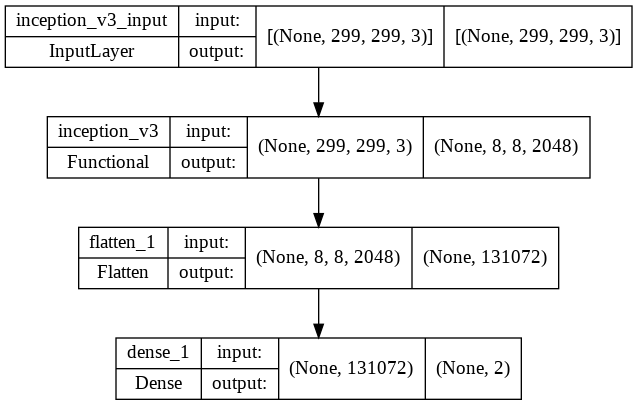

In [25]:
# obtaining a pictorial representation of the network
from tensorflow.keras.utils import plot_model
plot_model(model,  show_shapes=True, show_layer_names=True)

After that, we train the model on the training data generator with number of epochs set to 10 (optimum value set after trial and error of various combinations of accuracy and loss) and validation data to be used from the validation data generator.

In [26]:
# training the network
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
111/111 [==============================] - 21s 138ms/step - loss: 0.0738 - acc: 0.9755 - val_loss: 0.0323 - val_acc: 0.9950
Epoch 2/10
111/111 [==============================] - 11s 101ms/step - loss: 0.0103 - acc: 0.9977 - val_loss: 0.0070 - val_acc: 0.9950
Epoch 3/10
111/111 [==============================] - 11s 101ms/step - loss: 0.0060 - acc: 0.9977 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 4/10
111/111 [==============================] - 11s 100ms/step - loss: 0.0028 - acc: 0.9986 - val_loss: 9.0414e-05 - val_acc: 1.0000
Epoch 5/10
111/111 [==============================] - 11s 99ms/step - loss: 4.0109e-05 - acc: 1.0000 - val_loss: 6.5241e-05 - val_acc: 1.0000
Epoch 6/10
111/111 [==============================] - 11s 99ms/step - loss: 2.3467e-05 - acc: 1.0000 - val_loss: 6.5254e-05 - val_acc: 1.0000
Epoch 7/10
111/111 [==============================] - 11s 99ms/step - loss: 1.9854e-05 - acc: 1.0000 - val_loss: 6.7839e-05 - val_acc: 1.0000
Epoch 8/10
111/111 [==========

We then compare the training and validation accuracies. To do this, we use the history attribute and extract the accuracies of the models. Next, we plot it against the number of epochs using functions from the MatPlotLib library.

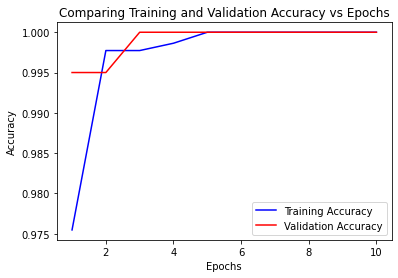

In [27]:
# extracting the model accuracy against epochs
ta = history.history['acc']
va = history.history['val_acc']
epochs = range(1,11)

# plotting the accuracies
plt.figure()
plt.plot(epochs, ta, 'b', label='Training Accuracy')
plt.plot(epochs, va, 'r', label='Validation Accuracy')
plt.title('Comparing Training and Validation Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

As we can see, the training accuracy increases sharply, starting low, whereas the validation accuracy increases slightly, starting high. Eventually, both the training and validation accuracy are almost the same.

Next, we compare the training and validation losses. To do this, we use the history attribute and extract the losses of the models. Next, we plot it against the number of epochs using functions from the MatPlotLib library.

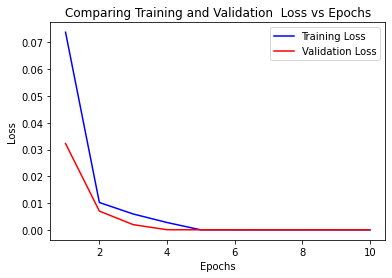

In [28]:
# extracting the model loss against epochs
tl = history.history['loss']
vl = history.history['val_loss']
epochs = range(1,11)

# plotting the losses
plt.figure()
plt.plot(epochs, tl, 'b', label='Training Loss')
plt.plot(epochs, vl, 'r', label='Validation Loss')
plt.title('Comparing Training and Validation  Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

As we can see, the training loss decreases sharply, whereas the validation loss has a slight downward trend leading to a plateau. Eventually, the training and validation loss are almost similar.

To evaluate the performance of the model on the test set, we use the evaluate() function and print the model's accuracy on the testing set.

In [29]:
# evaluating the model on the testing set
print(str.format('Accuracy on Test Set: {:.2f}%', model.evaluate(test_generator)[1]*100))

13/13 [==============================] - 1s 91ms/step - loss: 0.0806 - acc: 0.9846
Accuracy on Test Set: 98.46%


As we can see, the model has an accuracy of 98.46% on the test set, indicating that the model performs very well.

## ResNet50

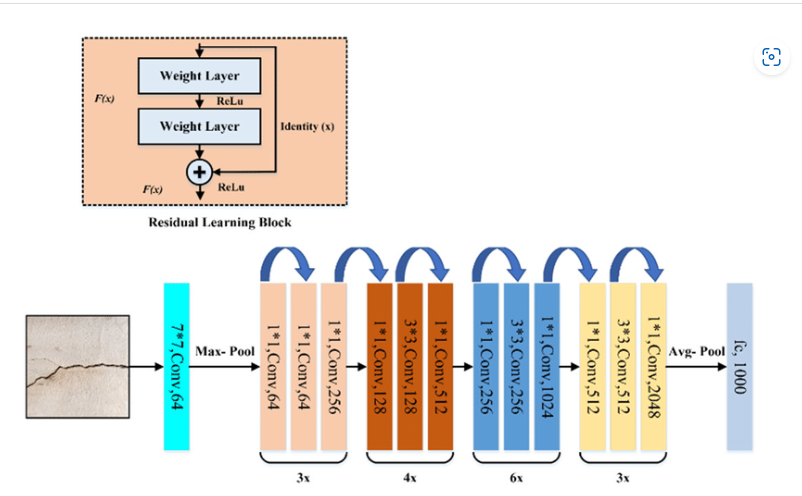

To begin, we implement the previously created data generators to generate the train, test, and validation sets and resize the images to 224x224 for the network implementation.

In [31]:
# flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size=(224, 224), # resclaing the images to 224 x 224
        batch_size=20,
        class_mode='categorical')

Found 2201 images belonging to 2 classes.


In [32]:
# flow validation images in batches of 20 using val_datagen generator
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224), # resclaing the images to 224 x 224
    batch_size=20,
    class_mode='categorical'
)

Found 200 images belonging to 2 classes.


In [33]:
# flow testing images in batches of 20 using test_datagen generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224), # resclaing the images to 224 x 224
        batch_size=20,
        class_mode='categorical')

Found 260 images belonging to 2 classes.


Next, we use the concept of Transfer Learning to use ResNet's pre-trained weights and biases for image classification. To do this, we import the base model of ResNet from the Keras library.

In [34]:
# importing the network
from keras.applications.resnet import ResNet50
base_model = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)
base_model.trainable = False # freezing the layers
base_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

After that, we add in a Deep Neural Network at the tail of the base model which flattens the features generated during convolution to make predictions using 2 nodes and the 'sigmoid' activation. We also compile the model and set the optimizer to be 'adam' with learning rate to be 0.0001, loss to be 'categorical_crossentropy' and metric to be 'accuracy'

In [35]:
# adding a deep neural network to make predictions
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='sigmoid')
])
model.summary()

# compiling the network
model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['acc'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 2)                 200706    
                                                                 
Total params: 23,788,418
Trainable params: 200,706
Non-trainable params: 23,587,712
_________________________________________________________________


To obtain a pictorial representation of the network, we use the plot_model() function from the Tensorflow library.

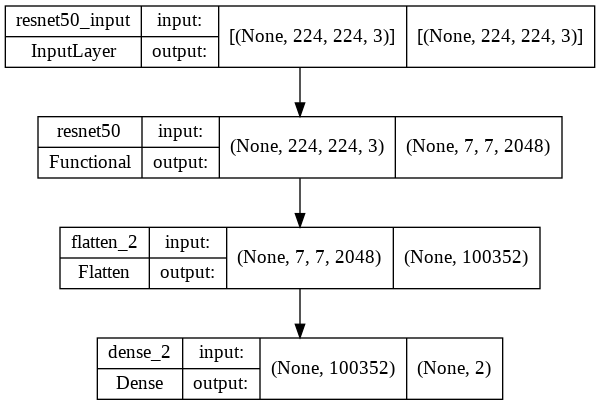

In [36]:
# obtaining a pictorial representation of the network
from tensorflow.keras.utils import plot_model
plot_model(model,  show_shapes=True, show_layer_names=True)

After that, we train the model on the training data generator with number of epochs set to 10 (optimum value set after trial and error of various combinations of accuracy and loss) and validation data to be used from the validation data generator.

In [37]:
# training the network
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
111/111 [==============================] - 15s 99ms/step - loss: 0.5424 - acc: 0.7183 - val_loss: 0.4650 - val_acc: 0.7800
Epoch 2/10
111/111 [==============================] - 10s 86ms/step - loss: 0.4150 - acc: 0.8114 - val_loss: 0.5199 - val_acc: 0.7250
Epoch 3/10
111/111 [==============================] - 10s 86ms/step - loss: 0.3948 - acc: 0.8269 - val_loss: 0.3850 - val_acc: 0.8450
Epoch 4/10
111/111 [==============================] - 10s 86ms/step - loss: 0.3479 - acc: 0.8433 - val_loss: 0.3547 - val_acc: 0.8500
Epoch 5/10
111/111 [==============================] - 10s 85ms/step - loss: 0.3368 - acc: 0.8582 - val_loss: 0.3502 - val_acc: 0.8700
Epoch 6/10
111/111 [==============================] - 10s 85ms/step - loss: 0.3215 - acc: 0.8582 - val_loss: 0.3382 - val_acc: 0.8600
Epoch 7/10
111/111 [==============================] - 9s 85ms/step - loss: 0.3142 - acc: 0.8619 - val_loss: 0.3652 - val_acc: 0.8400
Epoch 8/10
111/111 [==============================] - 9s 85ms/s

We then compare the training and validation accuracies. To do this, we use the history attribute and extract the accuracies of the models. Next, we plot it against the number of epochs using functions from the MatPlotLib library.

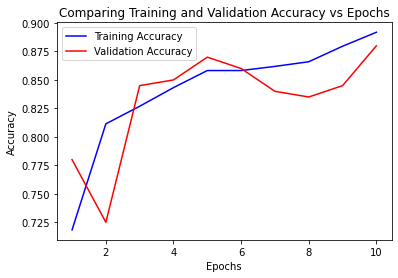

In [38]:
# extracting the model accuracy against epochs
ta = history.history['acc']
va = history.history['val_acc']
epochs = range(1,11)

# plotting the accuracies
plt.figure()
plt.plot(epochs, ta, 'b', label='Training Accuracy')
plt.plot(epochs, va, 'r', label='Validation Accuracy')
plt.title('Comparing Training and Validation Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

As we can see, both the training and validation accuracies have an upward trend, however, the validation accuracy fluctuates a lot. There is not much difference between the two.

Next, we compare the training and validation losses. To do this, we use the history attribute and extract the losses of the models. Next, we plot it against the number of epochs using functions from the MatPlotLib library.

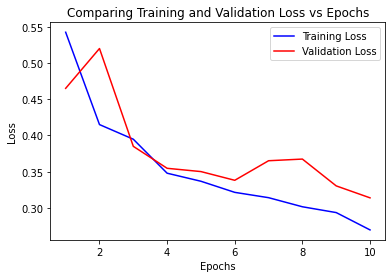

In [39]:
# extracting the model loss against epochs
tl = history.history['loss']
vl = history.history['val_loss']
epochs = range(1,11)

# plotting the losses
plt.figure()
plt.plot(epochs, tl, 'b', label='Training Loss')
plt.plot(epochs, vl, 'r', label='Validation Loss')
plt.title('Comparing Training and Validation Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

As we can see, both the training and validation losses have a downward trend, however, the validation losses fluctuates a lot. There is not much difference between the two.

To evaluate the performance of the model on the test set, we use the evaluate() function and print the model's accuracy on the testing set.

In [40]:
# evaluating the model on the testing set
print(str.format('Accuracy on Test Set: {:.2f}%', model.evaluate(test_generator)[1]*100))

13/13 [==============================] - 1s 78ms/step - loss: 0.3059 - acc: 0.8692
Accuracy on Test Set: 86.92%


As we can see, the network has an accuracy of 86.92% on the testing set, which indicates that the model performs well.

## EfficientNetB0

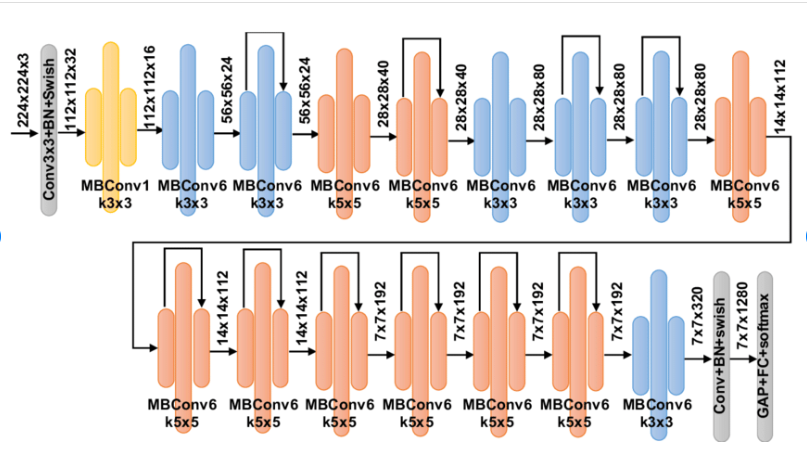

To begin, we implement the previously created data generators to generate the train, test, and validation sets and resize the images to 224x224 for the network implementation.

In [42]:
# flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size=(224, 224), # resclaing the images to 224 x 224
        batch_size=20,
        class_mode='categorical')

Found 2201 images belonging to 2 classes.


In [43]:
# flow validation images in batches of 20 using val_datagen generator
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224), # resclaing the images to 224 x 224
    batch_size=20,
    class_mode='categorical'
)

Found 200 images belonging to 2 classes.


In [44]:
# flow testing images in batches of 20 using test_datagen generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224), # resclaing the images to 224 x 224
        batch_size=20,
        class_mode='categorical')

Found 260 images belonging to 2 classes.


Next, we use the concept of Transfer Learning to use EfficientNetB0's pre-trained weights and biases for image classification. To do this, we import the base model of EfficientNetB0 from the Keras library.

In [45]:
# importing the network
from keras.applications.efficientnet import EfficientNetB0
base_model = EfficientNetB0(input_shape=(224,224,3), weights='imagenet', include_top=False)
base_model.trainable = False # freezing the layers
base_model.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (Zero

After that, we add in a Deep Neural Network at the tail of the base model which flattens the features generated during convolution to make predictions using 2 nodes and the 'sigmoid' activation. We also compile the model and set the optimizer to be 'adam' with learning rate to be 0.0001, loss to be 'categorical_crossentropy' and metric to be 'accuracy'

In [46]:
# adding a deep neural network to make predictions
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='sigmoid')
])
model.summary()

# compiling the network
model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['acc'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 flatten_3 (Flatten)         (None, 62720)             0         
                                                                 
 dense_3 (Dense)             (None, 2)                 125442    
                                                                 
Total params: 4,175,013
Trainable params: 125,442
Non-trainable params: 4,049,571
_________________________________________________________________


To obtain a pictorial representation of the network, we use the plot_model() function from the Tensorflow library.

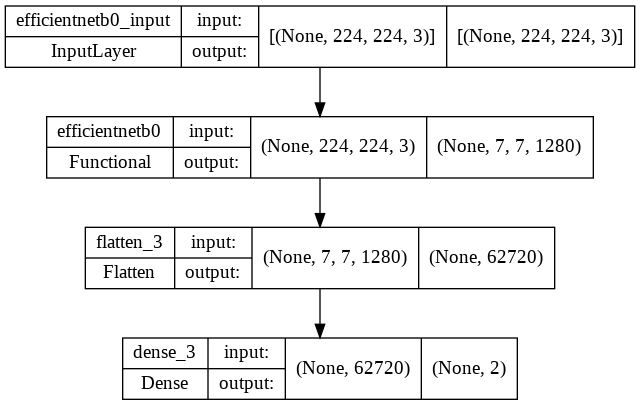

In [47]:
# obtaining a pictorial representation of the network
from tensorflow.keras.utils import plot_model
plot_model(model,  show_shapes=True, show_layer_names=True)

After that, we train the model on the training data generator with number of epochs set to 10 (optimum value set after trial and error of various combinations of accuracy and loss) and validation data to be used from the validation data generator.

In [48]:
# training the network
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
111/111 [==============================] - 17s 88ms/step - loss: 0.7450 - acc: 0.5279 - val_loss: 0.7914 - val_acc: 0.5000
Epoch 2/10
111/111 [==============================] - 8s 71ms/step - loss: 0.7431 - acc: 0.5234 - val_loss: 0.6842 - val_acc: 0.5050
Epoch 3/10
111/111 [==============================] - 8s 69ms/step - loss: 0.7276 - acc: 0.5220 - val_loss: 0.6694 - val_acc: 0.6850
Epoch 4/10
111/111 [==============================] - 8s 70ms/step - loss: 0.7360 - acc: 0.5143 - val_loss: 0.6793 - val_acc: 0.5350
Epoch 5/10
111/111 [==============================] - 8s 70ms/step - loss: 0.7061 - acc: 0.5393 - val_loss: 0.6725 - val_acc: 0.5000
Epoch 6/10
111/111 [==============================] - 8s 69ms/step - loss: 0.7603 - acc: 0.5534 - val_loss: 0.6914 - val_acc: 0.5050
Epoch 7/10
111/111 [==============================] - 8s 69ms/step - loss: 0.7561 - acc: 0.5175 - val_loss: 0.6888 - val_acc: 0.5050
Epoch 8/10
111/111 [==============================] - 8s 69ms/step -

We then compare the training and validation accuracies. To do this, we use the history attribute and extract the accuracies of the models. Next, we plot it against the number of epochs using functions from the MatPlotLib library.

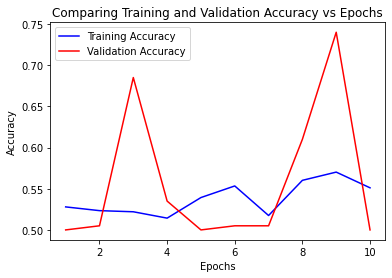

In [49]:
# extracting the model accuracy against epochs
ta = history.history['acc']
va = history.history['val_acc']
epochs = range(1,11)

# plotting the accuracies
plt.figure()
plt.plot(epochs, ta, 'b', label='Training Accuracy')
plt.plot(epochs, va, 'r', label='Validation Accuracy')
plt.title('Comparing Training and Validation Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

As we can see, the training and validation accuracies donot have a significant trend, however, the validation accuracy fluctuates a lot. There is sometimes a significant difference and sometimes a negligible difference between the two.

Next, we compare the training and validation losses. To do this, we use the history attribute and extract the losses of the models. Next, we plot it against the number of epochs using functions from the MatPlotLib library.

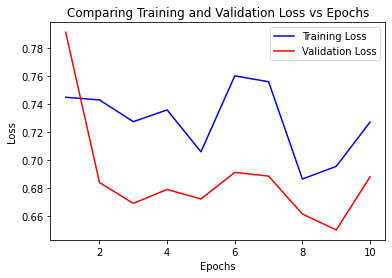

In [50]:
# extracting the model loss against epochs
tl = history.history['loss']
vl = history.history['val_loss']
epochs = range(1,11)

# plotting the losses
plt.figure()
plt.plot(epochs, tl, 'b', label='Training Loss')
plt.plot(epochs, vl, 'r', label='Validation Loss')
plt.title('Comparing Training and Validation Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

As we can see, there is a slight downward trend in both the training and validation loss, and fluctuations are present in both. There is also some difference between the two.

To evaluate the performance of the model on the test set, we use the evaluate() function and print the model's accuracy on the testing set.

In [51]:
# evaluating the model on the testing set
print(str.format('Accuracy on Test Set: {:.2f}%', model.evaluate(test_generator)[1]*100))

13/13 [==============================] - 1s 64ms/step - loss: 0.6674 - acc: 0.5385
Accuracy on Test Set: 53.85%


As we can see, the network has an accuracy of 53.85% on the test set, which indicates that the model does not perform very well.

## MobileNetV2

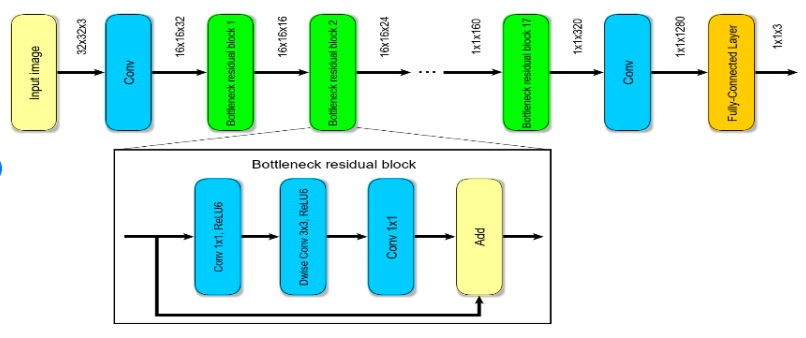

To begin, we implement the previously created data generators to generate the train, test, and validation sets and resize the images to 224x224 for the network implementation.

In [53]:
# flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(224, 224), # resclaing the images to 224 x 224
        batch_size=20,
        class_mode='categorical')

Found 2201 images belonging to 2 classes.


In [54]:
# flow validation images in batches of 20 using val_datagen generator
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224), # resclaing the images to 224 x 224
    batch_size=20,
    class_mode='categorical'
)

Found 200 images belonging to 2 classes.


In [55]:
# flow testing images in batches of 20 using test_datagen generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224), # resclaing the images to 224 x 224
        batch_size=20,
        class_mode='categorical')

Found 260 images belonging to 2 classes.


Next, we use the concept of Transfer Learning to use MobileNetV2's pre-trained weights and biases for image classification. To do this, we import the base model of MobileNetV2 from the Keras library.

In [56]:
# importing the network
from keras.applications.mobilenet_v2 import MobileNetV2
base_model = MobileNetV2(input_shape=(224,224,3), weights='imagenet', include_top=False)
base_model.trainable = False # freezing the layers
base_model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

After that, we add in a Deep Neural Network at the tail of the base model which flattens the features generated during convolution to make predictions using 2 nodes and the 'sigmoid' activation. We also compile the model and set the optimizer to be 'adam' with learning rate to be 0.0001, loss to be 'categorical_crossentropy' and metric to be 'accuracy'

In [57]:
# adding a deep neural network to make predictions
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='sigmoid')
])
model.summary()

# compiling the network
model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['acc'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_4 (Flatten)         (None, 62720)             0         
                                                                 
 dense_4 (Dense)             (None, 2)                 125442    
                                                                 
Total params: 2,383,426
Trainable params: 125,442
Non-trainable params: 2,257,984
_________________________________________________________________


To obtain a pictorial representation of the network, we use the plot_model() function from the Tensorflow library.

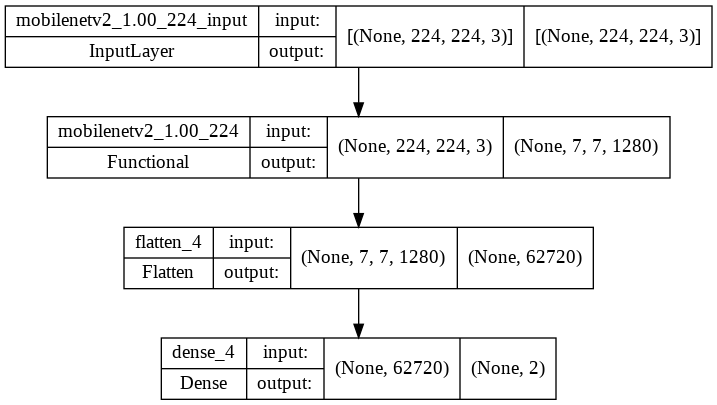

In [58]:
# obtaining a pictorial representation of the network
from tensorflow.keras.utils import plot_model
plot_model(model,  show_shapes=True, show_layer_names=True)

After that, we train the model on the training data generator with number of epochs set to 10 (optimum value set after trial and error of various combinations of accuracy and loss) and validation data to be used from the validation data generator.

In [59]:
# training the network
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
111/111 [==============================] - 11s 76ms/step - loss: 0.1050 - acc: 0.9637 - val_loss: 0.0458 - val_acc: 0.9850
Epoch 2/10
111/111 [==============================] - 7s 66ms/step - loss: 0.0082 - acc: 0.9977 - val_loss: 0.0405 - val_acc: 0.9900
Epoch 3/10
111/111 [==============================] - 7s 64ms/step - loss: 7.7833e-04 - acc: 1.0000 - val_loss: 0.0381 - val_acc: 0.9900
Epoch 4/10
111/111 [==============================] - 7s 64ms/step - loss: 4.0989e-04 - acc: 1.0000 - val_loss: 0.0386 - val_acc: 0.9900
Epoch 5/10
111/111 [==============================] - 7s 64ms/step - loss: 3.0270e-04 - acc: 1.0000 - val_loss: 0.0400 - val_acc: 0.9900
Epoch 6/10
111/111 [==============================] - 7s 64ms/step - loss: 2.4744e-04 - acc: 1.0000 - val_loss: 0.0403 - val_acc: 0.9900
Epoch 7/10
111/111 [==============================] - 7s 63ms/step - loss: 2.0889e-04 - acc: 1.0000 - val_loss: 0.0407 - val_acc: 0.9900
Epoch 8/10
111/111 [============================

We then compare the training and validation accuracies. To do this, we use the history attribute and extract the accuracies of the models. Next, we plot it against the number of epochs using functions from the MatPlotLib library.

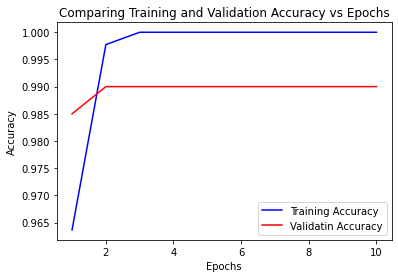

In [60]:
# extracting the model accuracy against epochs
ta = history.history['acc']
va = history.history['val_acc']
epochs = range(1,11)

# plotting the accuracies
plt.figure()
plt.plot(epochs, ta, 'b', label='Training Accuracy')
plt.plot(epochs, va, 'r', label='Validatin Accuracy')
plt.title('Comparing Training and Validation Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

As we can see, the training accuracy increases sharply, and then plateaus starting low, whereas the validation accuracy increases slightly and then plateaus starting high. There is not much difference between the two.

Next, we compare the training and validation losses. To do this, we use the history attribute and extract the losses of the models. Next, we plot it against the number of epochs using functions from the MatPlotLib library.

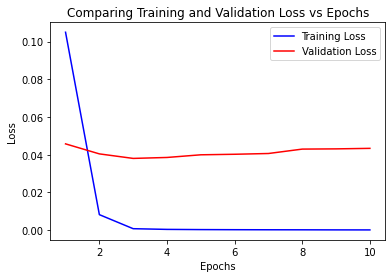

In [61]:
# extracting the model loss against epochs
tl = history.history['loss']
vl = history.history['val_loss']
epochs = range(1,11)

# plotting the losses
plt.figure()
plt.plot(epochs, tl, 'b', label='Training Loss')
plt.plot(epochs, vl, 'r', label='Validation Loss')
plt.title('Comparing Training and Validation Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

As we can see, the training loss decreases sharply and then plateuas startin high, whereas the validation loss remains almost constant. There is not much difference between the two.

To evaluate the performance of the model on the test set, we use the evaluate() function and print the model's accuracy on the testing set.

In [62]:
# evaluating the model on the testing set
print(str.format('Accuracy on Test Set: {:.2f}%', model.evaluate(test_generator)[1]*100))

13/13 [==============================] - 1s 58ms/step - loss: 0.1019 - acc: 0.9846
Accuracy on Test Set: 98.46%


As we can see, the network has an accuracy of 98.46% on the test set, which indicates that the model performs very well.